# Business Problem

The Tanzania Development Trust is a UK charitable organization operating within the country of Tanzania since 1975.

They focus on development in rural Tanzania, aiming to support small projects in the poorest parts of the country where one of their priority areas of funding is clean water. Their stated water project involves boreholing and rope pump installation in areas with limited access to clean water, currently located in the regions of Kagera and Kigoma in the northwest of the country.

A new benefactor wants to expand the project not only geographically to more of the country, but in the scope of repairing existing pumps before they fail. I have been tasked with developing a model to predict the operating condition of a current waterpoint: functional, needs repair, or non-functional.

The main objective is to identify waterpoints that are in need of repair. [Research shows](https://sswm.info/entrepreneurship-resource/developing-impactful-businesses/maintenance-services-for-rural-water-pumps) that it is much less expensive to repair and rehabilitate a waterpoint, as well as being more protective of the water resources in the country. 
The secondary objective is to identify concentrations of non-functioning water points that may be an eligible location for a new installation.
______________________
The data provided for modeling contains the information for 59,400 water points in Tanzania across 40 features

# Imports

In [1]:
import random

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42)

In [2]:
# import training data and target
raw_data = pd.read_csv('data/training_data.csv')
raw_target = pd.read_csv('data/training_target.csv')

display(raw_target.info())
print(raw_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            59400 non-null  int64 
 1   status_group  59400 non-null  object
dtypes: int64(1), object(1)
memory usage: 928.2+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

Create a raw dataframe with merged data and target. We will use this df during initial EDA so we can compare feature relationships with target, and so we can understand and deal with null values

In [3]:
raw_df = pd.merge(raw_data, raw_target, on='id')

The dataset for training includes 59,400 entries with 39 total features, a unique identifier, and a target label.

In [4]:
status_values = pd.DataFrame(raw_df.status_group.value_counts())
status_values.columns = ['count']
status_values['percent'] = round(raw_df.status_group.value_counts(normalize=True) * 100, 1)
status_values

,count,percent
functional,32259,54.3
non functional,22824,38.4
functional needs repair,4317,7.3


This is a ternary classification problem. The three possible values are:
- functional (F)
- non functional (NF)
- functional needs repair (FR)

Value counts show that our dataset is not balanced with respect to the label values. Only 7.3% of pumps are classified as functional needs repair, while 54.3% are functional and 38.4% are non functional. We will need to keep this imbalance in mind when modeling.
_________
We are going to change our target to numerical values, 
where:
- 'non function' will equal: 0
- 'functional needs repair' will equal: 1
- 'functional' will equal: 2

In [5]:
status_dict = {'non functional': 0,
              'functional needs repair': 1,
              'functional': 2}

raw_df['target'] = raw_df['status_group'].map(lambda x: status_dict[x])
raw_df.drop('status_group', axis=1, inplace=True)

# Null Checks

In [6]:
null_checks = pd.DataFrame(data=raw_df.isna().sum(),
                          columns=['null_count'])
null_checks['percent_of_data'] = round((null_checks.null_count / len(raw_data)) * 100, 1)
null_checks = null_checks[null_checks.percent_of_data > 0.1]
null_checks.sort_values('percent_of_data', ascending=False, inplace=True)
null_checks

,null_count,percent_of_data
scheme_name,28166,47.4
scheme_management,3877,6.5
installer,3655,6.2
funder,3635,6.1
public_meeting,3334,5.6
permit,3056,5.1
subvillage,371,0.6


There are 7 features with null values in our dataset, and we can what that number of nulls is by percent of total available data. 
______
All of the features that contain null values are object types and will need to be converted. Before conversion we will need to address the null values.

## subvillage

In [7]:
subvillage_nans = raw_df[raw_df.subvillage.isnull()]
round(subvillage_nans.target.value_counts(normalize=True) * 100, 2)

2    55.26
0    44.47
1     0.27
Name: target, dtype: float64

The null values in subvillage represent 0.6% of our total data. The distribution of the target label is close to the whole dataset

In [8]:
subvillage_nans.region.value_counts()

Dodoma    361
Mwanza     10
Name: region, dtype: int64

All but 10 of our subvillage nan's come from the region of Dodoma, the rest from Mwanza. Lets look at the subvillage distribution of those regions from the whole dataset

In [9]:
raw_df[raw_df['region'] == 'Dodoma'].subvillage.value_counts()

Kawawa         54
Shuleni        43
Nyerere        35
Azimio         34
Majengo        32
               ..
Foye            1
Mtatangwe       1
Makao Mapya     1
Soya Mjini      1
Mgomwa          1
Name: subvillage, Length: 705, dtype: int64

In [10]:
raw_df[raw_df['region'] == 'Mwanza'].subvillage.value_counts()

1                     132
Madukani               52
Bujingwa               25
Shuleni                19
Matale                 18
                     ... 
Bukalo                  1
Nyambona                1
Kabaganda B             1
Bulyahilu Center B      1
Mwambogwa               1
Name: subvillage, Length: 1507, dtype: int64

There are no average or overwhelmingly dominant subvillages that we could assign the null values to. In fact, the total unique value count of subvillages in Dodoma is double the quantity of missing values! It's not clear if we will use subvillage in modeling, so we will change null values to 'Other'

In [11]:
raw_df['subvillage'].fillna(value='Other', inplace=True)

## permit

In [12]:
permit_nans = raw_df[raw_df.permit.isnull()]
permit_nans.reset_index(drop=True, inplace=True)
round(permit_nans.target.value_counts(normalize=True) * 100, 2)

2    54.74
0    35.44
1     9.82
Name: target, dtype: float64

5% of our dataset have no value for permit. Distribution of the target label is approximately the same as the whole dataset.

In [13]:
permit_distribution = raw_df.permit.value_counts(normalize=True)
permit_distribution

True     0.68955
False    0.31045
Name: permit, dtype: float64

Per the data documentation, the permit feature is if the water point is permitted or not. Data we do have for this feature show it's about 70/30 in favor of permitted.

We will randomly fill these 3056 missing datapoints with true/false in the same ratio we found in our entire dataset.

In [14]:
raw_df['permit'] = raw_df['permit'].fillna(pd.Series(np.random.choice([True, False],
                                                       p=list(permit_distribution),
                                                       size=len(raw_df))))

## public_meeting

In [15]:
public_meeting_nans = raw_df[raw_df.public_meeting.isnull()]
public_meeting_nans.reset_index(drop=True, inplace=True)
round(public_meeting_nans.target.value_counts(normalize=True) * 100, 2)

2    50.33
0    44.99
1     4.68
Name: target, dtype: float64

5.6% of our dataset has no value for public_meeting. Distribution of the target label is approximately the same as the whole dataset.

In [16]:
meeting_distribution = raw_df.public_meeting.value_counts(normalize=True)
meeting_distribution

True     0.909838
False    0.090162
Name: public_meeting, dtype: float64

The public meeting feature is a boolean that is over 90% true for data we do have. We will fill null values in the same percentages.

In [17]:
raw_df['public_meeting'] = raw_df['public_meeting'].fillna(
    pd.Series(np.random.choice([True, False],
                               p=list(meeting_distribution),
                               size=len(raw_df))))

## funder & installer

The features 'funder' and 'installer' have almost the same number of null values; I am curious about the overlap of nulls.

In [18]:
# dividing the number of entries with null for both features by the smaller count
len(raw_df[raw_df.funder.isnull() & raw_df.installer.isnull()]) / null_checks.null_count['funder']

0.9854195323246218

Over 98% of the null values for funder also contain null values for installer.
________

In [19]:
funder_df = pd.DataFrame(round(raw_df.funder.value_counts(normalize=True, dropna=False) * 100, 2))
funder_df

,funder
Government Of Tanzania,15.29
NaN,6.12
Danida,5.24
Hesawa,3.71
Rwssp,2.31
...,...
Rarymond Ekura,0.00
Justine Marwa,0.00
Municipal Council,0.00
Afdp,0.00


In [20]:
funder_df_top = funder_df[funder_df.funder > 1.0]
print(f"Funders with more than 1% share: {len(funder_df_top)}")
print(f"Percent of total funders represented by above: {funder_df_top.sum()}")

Funders with more than 1% share: 18
Percent of total funders represented by above: funder    52.69
dtype: float64


Including null values, there were 1,898 distinct values for funder. Of that, 18 values (including null) have representative counts more than 1% of total data.

Those 18 distinct values represent almost 53% of our total data. We will convert null values to 'Other'. There are still lots of unique values, so something to consider is converting all funders with less than 1% total share as 'Other' to reduce the unique value count.

In [21]:
installer_df = pd.DataFrame(round(raw_df.installer.value_counts(normalize=True, dropna=False) * 100, 2))
installer_df

,installer
DWE,29.30
NaN,6.15
Government,3.07
RWE,2.03
Commu,1.78
...,...
Wizara ya maji,0.00
TWESS,0.00
Nasan workers,0.00
R,0.00


In [22]:
installer_df_top = installer_df[installer_df.installer > 1.0]
print(f"Installers with more than 1% share: {len(installer_df_top)}")
print(f"Percent of total installers represented by above: {installer_df_top.sum()}")

Installers with more than 1% share: 12
Percent of total installers represented by above: installer    51.6
dtype: float64


Similarly to funder, the installer feature is dominated by small share installers. Of the 2,146 distinct values for installer, 12 values (including null) have representative counts more than 1% of total data.

Those 12 distinct values represent almost 52% of our total data. This is similar to the funder feature. We will also convert null values to 'Other', and will consider converting all installers with less than 1% total share of installer as 'Other' to reduce the unique value count. 

In [23]:
raw_df['funder'].fillna(value='Other', inplace=True)
raw_df['installer'].fillna(value='Other', inplace=True)

## scheme_management

In [24]:
scheme_management_nans = raw_df[raw_df.scheme_management.isnull()]
scheme_management_nans.reset_index(drop=True, inplace=True)
round(scheme_management_nans.target.value_counts(normalize=True) * 100, 2)

2    48.31
0    45.94
1     5.75
Name: target, dtype: float64

In [25]:
raw_df.scheme_management.value_counts(normalize=True, dropna=False)

VWC                 0.619411
WUG                 0.087643
NaN                 0.065269
Water authority     0.053081
WUA                 0.048535
Water Board         0.046263
Parastatal          0.028283
Private operator    0.017896
Company             0.017862
Other               0.012896
SWC                 0.001633
Trust               0.001212
None                0.000017
Name: scheme_management, dtype: float64

6.5% of our data has no value for scheme_management. Distribution of the target data is approximately the same as the whole dataset.
_________
There was only one entry with the value of 'None', we will change that to 'Other'

In [26]:
raw_df.at[23603, 'scheme_management'] = 'Other'

We will fill null values for scheme_management randomly with other values from the feature in the same percentage.

In [27]:
scheme_management_list = pd.DataFrame(raw_df.scheme_management.value_counts(normalize=True))
scheme_management_list

,scheme_management
VWC,0.662662
WUG,0.093763
Water authority,0.056787
WUA,0.051924
Water Board,0.049493
Parastatal,0.030258
Private operator,0.019145
Company,0.019109
Other,0.013814
SWC,0.001747


In [28]:
raw_df['scheme_management'] = raw_df['scheme_management'].fillna(
    pd.Series(np.random.choice(list(scheme_management_list.index),
                               p=list(scheme_management_list.scheme_management),
                               size=len(raw_df))))

## scheme_name

In [29]:
raw_df.scheme_name.value_counts(normalize=True, dropna=False)

NaN                        0.474175
K                          0.011481
None                       0.010842
Borehole                   0.009192
Chalinze wate              0.006818
                             ...   
Visiga water supplly       0.000017
Emanyata pipelines         0.000017
Magundi water supply       0.000017
Imalampaka water supply    0.000017
Mtawanya                   0.000017
Name: scheme_name, Length: 2697, dtype: float64

Almost half (47%) of the scheme_name feature contains no data, and the remaining data contains 2,697 distinct other features, none of which exceed 1% of the dataset. Lets look a little closer to see what else we can figure out.

In [30]:
scheme_name = pd.DataFrame(raw_df.scheme_name.value_counts(dropna=False))
scheme_name[scheme_name.scheme_name > 75]

,scheme_name
NaN,28166
K,682
None,644
Borehole,546
Chalinze wate,405
M,400
DANIDA,379
Government,320
Ngana water supplied scheme,270
wanging'ombe water supply s,261


The scheme name, per the documentation, is the individual or group that actually operates the waterpoint. This is compared to the scheme management company, which oversees operation. When the data was collected, it looks like there was little organization with respect to this particular datapoint. Considering the there are no other patterns in the available names, and that we have the management data, we will likely not use this feature in modeling.
_____
We will replace null values with 'Other'

In [31]:
raw_df['scheme_name'].fillna(value='Other', inplace=True)

# Exploring numerical data

In [32]:
num_df = raw_df.select_dtypes(include=np.number).copy()
num_df.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,target
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475,1.158838
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547,0.949794
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000,2.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000,2.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000,2.000000


The 'id' feature is a unique identifier, we will leave it in for merge purposes later but will not use it in modeling so no investigation needed.

The 'amount_tsh' feature is the total amount of water available to the waterpoint. It looks like at least 50% of our waterpoints do not have any water available, regardless of pump functionality. If we look back, we also see that over 50% of pumps are classified as functional. This is a bit concerning, it's unclear how you can have a functional pump with no water available to pump.

'gps_height' is concerning. [Research shows](https://en.wikipedia.org/wiki/Geography_of_Tanzania) that the lowest point in the country is sea level (0), yet we have a minimum of -90, so we will need to investigate that.

[Research shows](https://worldpopulationreview.com/countries/tanzania/location) that Tanzania's most extreme latitudes range from 00&deg;59'S (-0.98333) to 11&deg;45'S (-11.75), while the longitude extremes range from 40&deg;29'E (40.48333) to 29&deg;10'E (29.16667)

The 'latitude' values seem to exceed the northen border of the country (max latitude -2e-08), so we will need to investigate that. The 'longitude' values minimum is 0, so we have some data that is outside the range of the country borders. It's likely from mistakes or errors in data entry, but we need to investigate the extent and fix it.

There is no description of 'num_private' in the datasource, we'll have to look at that. It may not factor into modeling.

'region_code' and 'district_code' will need to be investigated separately as well, the documentation is not clear about what that data represents.

'construction_year' and 'population' each have minimums of 0, and that should definitely not be the case in construction year. It's possible a waterpoint exists in a place considered to have no population, but we'll need to investigate these further.

## amount_tsh

In [33]:
len(num_df[num_df.amount_tsh == 0.0]) / len(num_df)

0.700993265993266

70% of our datapoints list the amount_tsh as equal to 0.0. This can't mean that the waterpoint has no water available. We need to understand more about what total static head means. [Research shows](https://www.pumpfundamentals.com/tutorial2.htm#:~:text=If%20the%20liquid%20surface%20of,the%20friction%20in%20the%20system.) that a pump system's static head is the difference between the liquid surface of the reservoir and the discharge end of the pump system. The higher the discharge tube is lifted above the liquid surface, the harder is is for the pump to move the water, and the lower the flow rate will be. I would imagine that the requirements of pump location to discharge would impact the type of pump to be used.

In [34]:
num_df.groupby('target').mean()[['amount_tsh']]

,amount_tsh
target,
0,123.481230
1,267.071577
2,461.798235


In [35]:
num_df[num_df.amount_tsh > 0]

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,target
0,69572,6000.0,1390,34.938093,-9.856322,0,11,5,109,1999,2
2,34310,25.0,686,37.460664,-3.821329,0,21,4,250,2009,2
5,9944,20.0,0,39.172796,-4.765587,0,4,8,1,2009,2
11,50409,200.0,1062,35.770258,-10.574175,0,10,5,250,1987,2
16,48451,500.0,1703,34.642439,-9.106185,0,11,4,35,1978,0
...,...,...,...,...,...,...,...,...,...,...,...
59385,34473,500.0,1327,33.951681,-2.021854,0,20,4,200,2011,2
59387,26640,100.0,25,39.176480,-6.957098,0,7,2,100,2000,2
59394,11164,500.0,351,37.634053,-6.124830,0,5,6,89,2007,0
59395,60739,10.0,1210,37.169807,-3.253847,0,3,5,125,1999,2


The average total static head increases with each pump status category, from 0 (non function) to 2 (functional). We will have to engineer this feature in some way in order to utilize it. Most of our values are 0, we have none that are below that, and the maximum value is 350,000 feet.

## gps_height

In [36]:
gps_height_neg = num_df[num_df.gps_height < 0]
print(f"Percent of total data: {round(len(gps_height_neg)/len(num_df)*100,2)}%")
gps_height_neg.describe()

Percent of total data: 2.52%


,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,target
count,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000
mean,37297.606952,313.013369,-19.993316,39.352801,-7.727535,0.506684,34.703877,15.531417,258.137032,1686.096257,1.073529
std,21119.500129,4017.641868,12.154136,0.458811,1.542230,7.155227,35.259116,21.812220,428.417873,726.379806,0.983446
min,150.000000,0.000000,-90.000000,38.614960,-10.946096,0.000000,4.000000,1.000000,1.000000,0.000000,0.000000
25%,19232.750000,0.000000,-28.000000,38.972421,-8.584131,0.000000,6.000000,1.000000,40.000000,1976.000000,0.000000
50%,36699.000000,0.000000,-18.000000,39.281546,-7.415977,0.000000,7.000000,5.000000,102.500000,2000.000000,2.000000
75%,55492.750000,50.000000,-11.000000,39.662349,-6.524902,0.000000,60.000000,13.000000,320.000000,2008.000000,2.000000
max,74211.000000,138000.000000,-1.000000,40.345193,-5.278598,150.000000,99.000000,67.000000,4520.000000,2013.000000,2.000000


There are 1,496 datapoints where the gps_height was less than 0, about 2.5% of our data. Earlier we mentioned that this should not be possible as the listed lowest elevation for Tanzania is 0 ft above sea level (at the Indian Ocean). [Research shows](https://eos-gnss.com/knowledge-base/articles/elevation-for-beginners) that most GPS units are designed to measure height based on the representation of the earth's surface as an 'ellipsoid', and it's perfectly possible to be standing at sea level where the reading should be 0 and have it be a negative number. 

Considering these data are almost all on the eastern edge of the country (lower longitudes) closer to the Indian Ocean, it is likely the sites are at or just above sea level and capable of producing negative height readings. Opportunity for further tuning could be to address this incosistency across all the data, shifting all datapoints to a more accurage representation of height. I do not think it would be as simple as shifting all values up by the largest negative difference. Because it's such a small percentage of our dataset, we will just set them to 0 rather than worry about adjusting all the values.

In [37]:
num_df.gps_height.clip(lower=0.0, inplace=True)

## longitude/latitude

The max longitude is within the boundaries, we need to examine all values below the actual minimum which is 29.16667.

In [38]:
longitude_errors = num_df[num_df.longitude < 29.16667]
longitude_errors.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,target
count,1812.000000,1812.0,1812.0,1812.0,1.812000e+03,1812.0,1812.000000,1812.000000,1812.0,1812.0,1812.000000
mean,37389.841060,0.0,0.0,0.0,-2.000000e-08,0.0,17.820088,2.497241,0.0,0.0,1.173289
std,21413.129962,0.0,0.0,0.0,3.309636e-24,0.0,1.023562,2.157389,0.0,0.0,0.870267
min,15.000000,0.0,0.0,0.0,-2.000000e-08,0.0,11.000000,1.000000,0.0,0.0,0.000000
25%,18481.750000,0.0,0.0,0.0,-2.000000e-08,0.0,17.000000,1.000000,0.0,0.0,0.000000
50%,37326.000000,0.0,0.0,0.0,-2.000000e-08,0.0,17.000000,1.000000,0.0,0.0,1.000000
75%,55509.750000,0.0,0.0,0.0,-2.000000e-08,0.0,19.000000,6.000000,0.0,0.0,2.000000
max,74193.000000,0.0,0.0,0.0,-2.000000e-08,0.0,19.000000,6.000000,0.0,0.0,2.000000


It looks like we have found that our data includes errors in GPS readings. These errors show up as longitude 0 and latitude -2e-0.8. These entries with GPS errors, however, do not account for all the population point values of 0, or the construction year values of 0, so we will still need to address them.

In [39]:
print(f"Percent of data with missing lat/long: {round((len(longitude_errors)/len(num_df))*100, 2)}%")

print(f"Total data with population of 0: {len(num_df[num_df.population == 0])}")
print(f"Total data with construction year of 0: {len(num_df[num_df.construction_year == 0])}")

Percent of data with missing lat/long: 3.05%
Total data with population of 0: 21381
Total data with construction year of 0: 20709


In [40]:
gps_errors = raw_df[raw_df.longitude == 0.0]
gps_errors.target.value_counts(normalize=True)

2    0.480132
0    0.306843
1    0.213024
Name: target, dtype: float64

In [41]:
gps_errors.region_code.value_counts()

17    1057
19     752
11       3
Name: region_code, dtype: int64

The missing GPS data comprises about 3% of our dataset, but contains a disproportionate number of the 'functional needs repair' value from the target, which we already have very little data for. Also, all of the missing GPS data comes from three regions: 11, 17, and 19. 

What we can do is take the average lat/long from the points we do have for those region_codes and fill our nulls with the average for that region_code with a little randomness added in.

In [42]:
# get the list of the region codes with errors
error_regions = list(gps_errors.region_code.value_counts().index)

for region in error_regions:
    # split the data based on longitude not being 0.0
    region_no_gps = num_df[(num_df.region_code == region) & (num_df.longitude == 0.0)]
    region_gps_data = num_df[(num_df.region_code == region) & (num_df.longitude != 0.0)]
    # get mean and std for the long/lat of gps data we have
    avg_long = region_gps_data[['longitude', 'latitude']].mean()[0]
    avg_lat = region_gps_data[['longitude', 'latitude']].mean()[1]
    long_std = region_gps_data[['longitude', 'latitude']].std()[0]
    lat_std = region_gps_data[['longitude', 'latitude']].std()[1]
    # initialize empty lists for random data to fill
    fill_long = []
    fill_lat = []
    # append to each list a random value within the standard deviation of the mean
    for x in range(len(region_no_gps)):
        fill_long.append(random.triangular(avg_long+long_std, avg_long-long_std))
        fill_lat.append(random.triangular(avg_lat+lat_std, avg_lat-lat_std))
        x += 1
    # convert the two lists into a dataframe
    fill_df = pd.DataFrame([fill_long, fill_lat]).transpose()
    fill_df.columns = ['longitude', 'latitude']
    # replace the missing GPS data with these randomized values
    num_df.loc[region_no_gps.index, ['longitude', 'latitude']] = fill_df

## num_private

In [43]:
num_df.num_private.value_counts(normalize=True)

0       0.987256
6       0.001364
1       0.001229
5       0.000774
8       0.000774
          ...   
42      0.000017
23      0.000017
136     0.000017
698     0.000017
1402    0.000017
Name: num_private, Length: 65, dtype: float64

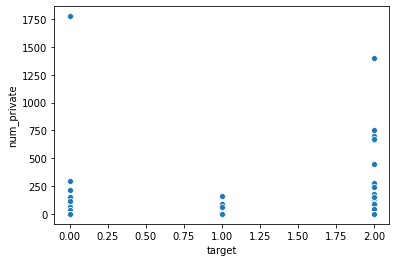

In [44]:
sns.scatterplot(data=num_df, x='target', y='num_private');

The vast majority of the num_private data has the value 0. There was no descriptor of the feature along with the others for the dataset, so we have no way to reference the value. 98% of the values in this feature are '0'. After looking at a quick scatterplot, we conclude it's very unlikely that there would be any statistically significant relationship between this feature and the target. We are going to drop it from num_df

In [45]:
num_df.drop('num_private', axis=1, inplace=True)

## region_code

What we suspect is that the regions are the parent in the relationship with district, and that each region has multiple districts in them. Since we have codes for region and strings for regions, lets compare them and see what we can discover.

In [46]:
print(f"Region numeric unique value count: {len(num_df.region_code.value_counts())}")
print(f"Region string unique value count: {len(raw_df.region.value_counts())}")
print("------------------------------------")
region_code_vals = list(map(str, list(num_df.region_code.value_counts().sort_index().index)))
print("Region_code values:")
print(", ".join(region_code_vals))
print("------------------------------------")
high_region_codes = raw_df[(num_df.region_code > 21)].copy()
print(f"Entries with region code > 21: {len(high_region_codes)}")
print(f"Percent of total data: {round(len(high_region_codes)/len(raw_df)*100, 2)}%")
print("------------------------------------")

Region numeric unique value count: 27
Region string unique value count: 21
------------------------------------
Region_code values:
1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 24, 40, 60, 80, 90, 99
------------------------------------
Entries with region code > 21: 3930
Percent of total data: 6.62%
------------------------------------


In [47]:
len(raw_df[(raw_df.region_code > 21)]) == len(raw_df[(raw_df.region_code > 21) & (raw_df.longitude != 0.0)])

True

We can see that the values of region_code go from 1 to 21, and then we have values 24, 40, 60, 80, 90, 99. It's likely that the values 1-21 match up to the 21 string value regions in the feature 'region'.

Entries with region_code values above 21 constitute 6.6% of our dataset, and all of the data categorized in these other region_codes contain correct lat/long data. (note: checked this using the raw_df, not the num_df we modified the missing lat/longs for)

As for the others, they serve some kind of purpose inputting data. We will need to figure out:
- What region_code matches to what region?
- What do the >21 region_code values mean?
_________
We are going to create a dataframe that goes through the region_codes 1-21 and adds the top reporting region/count from the value_count for that particular region_code. Then we look at any differences between those counts and the raw counts of entries with each region code.

In [48]:
region_code_list = []

for x in range(1, 22):
    region = raw_df[raw_df.region_code == x]['region'].value_counts().index[0]
    count = raw_df[raw_df.region_code == x]['region'].value_counts().values[0]
    region_code_list.append((x, region, count))
    
region_df = pd.DataFrame(region_code_list, columns=['region_code', 'region', 'region_count'])
region_df['region_code_count'] = raw_df.region_code.value_counts().sort_index().values[:21]

region_df['surplus_code_count'] = region_df['region_code_count'] - region_df['region_count']
region_df[region_df.surplus_code_count > 0]

,region_code,region,region_count,region_code_count,surplus_code_count
4,5,Morogoro,4006,4040,34
10,11,Iringa,5294,5300,6
13,14,Tabora,1959,1979,20
16,17,Shinyanga,4956,5011,55
17,18,Kagera,3316,3324,8


Of the 21 regions, 16 of them match up the region with a region_code and both features have the same count of values. There are 5 regions where the region_code value count has a surplus of values compared to the region value count.

For these few number of values, one thought is to update records for these region_codes so that all region_code values match to one region, i.e. we will update all rows where region_code is 5 so that the region 'Morogoro' is reflected. Just to be sure, lets look closer at this example.


In [49]:
raw_df[raw_df.region_code == 5].region.value_counts()

Morogoro    4006
Tanga         34
Name: region, dtype: int64

In [50]:
raw_df[(raw_df.region_code == 5) & (raw_df.region == 'Tanga')][['longitude', 'latitude']].describe()

,longitude,latitude
count,34.000000,34.000000
mean,37.180390,-6.039227
std,0.029752,0.025528
min,37.108257,-6.093574
25%,37.163602,-6.054215
50%,37.186427,-6.044506
75%,37.200669,-6.019999
max,37.231274,-5.992508


When we looked at the lat/long for the region_code 5 rows that have the region label 'Tanga', the most northern/eastern (min) value was within the boundary of the region 'Morogoro', but very close to the border. Tanga is the northern neighbor to region. We are going to make an assumption that these values of region_code reference the same region string, and assume that is also the case for the remaining surpluses. We will update those region values accordingly so that each region_code corresponds to one and only one region string. **Note: we are modifying the original raw_df here. We will then split off all categorical features in section 5 to encode. The 'region' feature is not a part of num_df**

In [51]:
fixes = list(zip(list(region_df[region_df.surplus_code_count > 0].region_code.values),
    list(region_df[region_df.surplus_code_count > 0].region.values)))

for fix in fixes:
    code = fix[0]
    region = fix[1]
    
    raw_df.loc[raw_df[(raw_df.region_code == code) & (raw_df.region != region)].index, 'region'] = region

________________

Now we need to examine the region_codes whose value is over 21 and figure out what they mean.

In [52]:
num_df[num_df.region_code > 21].region_code.value_counts()

80    1238
60    1025
90     917
99     423
24     326
40       1
Name: region_code, dtype: int64

We have about 6.6% of our data in these incorrectly labeled region_codes. We have just modified our raw_df dataframe and assigned all region values based on the (top) region_code value count. Lets look at our data grouped by region value and see the average for the region_code. If the average is an integer, we know that all entries for that region is the same number as the entries for the region_code (that value being the mean of the region_code feature). If it's not an integer, then it means that the region is represented by different region_codes and we can figure out which codes and reassign them correctly.

In [53]:
region_codes = raw_df.groupby('region')[['region_code']].mean().sort_values(by='region_code')
region_codes['is_int'] = region_codes.region_code.apply(lambda x: x.is_integer())
region_codes = region_codes[region_codes.is_int == False]
region_codes

,region_code,is_int
region,,
Arusha,4.140896,False
Pwani,27.018596,False
Lindi,65.955787,False
Mtwara,73.940462,False


We can see that these four regions are the ones without integer value region_code averages. We can deduce that all of the region_code values over 21 are attributed to these 4 regions. Now we will go through each region_code attributed to these regions and look at the lat/long averages. If they are in the same region, the averages should be fairly close in value.

In [54]:
# get the list of regions from above
regions = list(region_codes.index)

region_checks = []

# for each region, generate a row of data containing the region
for region in regions:
    codes = list(raw_df[raw_df.region == region].region_code.value_counts().index)
    for code in codes:
        long_avg = raw_df[raw_df.region_code == code][['longitude']].describe().loc[['mean']].longitude.values[0]
        lat_avg = raw_df[raw_df.region_code == code][['latitude']].describe().loc[['mean']].latitude.values[0]
        row = [region, code, long_avg, lat_avg]
        region_checks.append(row)

region_check_df = pd.DataFrame(region_checks,
                              columns = ['region','code','long_avg','lat_avg'])
region_check_df

,region,code,long_avg,lat_avg
0,Arusha,2,36.648738,-3.231963
1,Arusha,24,35.661985,-3.380886
2,Pwani,6,38.754707,-6.678934
3,Pwani,60,39.073593,-7.529581
4,Pwani,40,39.217993,-7.001266
5,Lindi,80,39.094711,-9.645071
6,Lindi,8,38.572954,-10.310537
7,Mtwara,90,38.958680,-10.805449
8,Mtwara,99,40.004465,-10.457718
9,Mtwara,9,39.771740,-10.628146


We cross-referenced the lat/long averages and can say that all the high-valued region_codes actually belong to an appropriate code for a region. Here we will reassign them correctly (in both the num_df dataframe and the raw_df dataframe so we have access to the region strings).

In [55]:
# all Arusha region codes should be 2
num_df.loc[raw_df[raw_df.region_code == 24].index, 'region_code'] = 2
raw_df.loc[raw_df[raw_df.region_code == 24].index, 'region_code'] = 2

# all Pwani region codes should be 6
num_df.loc[raw_df[raw_df.region_code.isin([40, 60])].index, 'region_code'] = 6
raw_df.loc[raw_df[raw_df.region_code.isin([40, 60])].index, 'region_code'] = 6

# all Lindi region codes should be 8
num_df.loc[raw_df[raw_df.region_code == 80].index, 'region_code'] = 8
raw_df.loc[raw_df[raw_df.region_code == 80].index, 'region_code'] = 8

# all Mtwara regions should be code 9
num_df.loc[raw_df[raw_df.region_code.isin([90, 99])].index, 'region_code'] = 9
raw_df.loc[raw_df[raw_df.region_code.isin([90, 99])].index, 'region_code'] = 9

We've got our 'region_code' feature all sorted out now and the values will match up uniquely with those in the 'region' feature.

## district_code

In [56]:
regions_with_codes = pd.DataFrame(raw_df.groupby('region').mean()['region_code'])
regions_with_codes.reset_index(inplace=True)
regions_with_codes['region_code'] = regions_with_codes.region_code.astype('int')
regions_with_codes.set_index('region_code', inplace=True)
regions_with_codes.sort_index(inplace=True)
regions_with_codes

,region
region_code,
1,Dodoma
2,Arusha
3,Kilimanjaro
4,Tanga
5,Morogoro
6,Pwani
7,Dar es Salaam
8,Lindi
9,Mtwara


We have established that the regions in our dataset match up with the region_code; there is no 'district' dataset to match with 'district_code'. When researching Tanzanian regions we discovered information on quantity of districts  in each region, so we believe that is how our data relates: each region would have multiple districts in it. Lets look at value counts for district_code.

In [57]:
num_df.district_code.value_counts().sort_index()

0        23
1     12203
2     11173
3      9998
4      8999
5      4356
6      4074
7      3343
8      1043
13      391
23      293
30      995
33      874
43      505
53      745
60       63
62      109
63      195
67        6
80       12
Name: district_code, dtype: int64

Some initial observations:
- It seems odd to have districts with a value of 0.
- [Research shows](https://en.wikipedia.org/wiki/Regions_of_Tanzania) that there is one region with 10 districts (Tanga), but we don't have that value. 
- 10 is is also the largest value we should have for the feature, as that is the maximum number of districts for regions.

_____
If it is the case that district_code is representative of the actual district within the region, then each region should have at minimum a district_code of 1. The link above will also show that regions at a minimum have 2 districts (the average is about 5.5). Lets go through and see if each region even has the correct number of districts per our research.

In [58]:
region = regions_with_codes[regions_with_codes.index == 2].region.values[0]
region

'Arusha'

In [59]:
district_info = []

for x in range(1, 22):
    # get our region name
    region = regions_with_codes[regions_with_codes.index == x].region.values[0]
    # use the num_df to list all the district codes with that region_code
    districts = sorted(list(num_df[num_df.region_code == x].district_code.value_counts().index))
    # create the row of data
    row = [region, len(districts), districts]
    # append to list
    district_info.append(row)

district_info_df = pd.DataFrame(district_info,
                               columns=['region','district_count', 'district_values'])
district_info_df.sort_values(by='region', inplace=True)
# input expected district count from research (based on alphabetical order of region in our data)
district_info_df['expected_district_count'] = [7, 5, 7, 5, 8, 8, 6, 6, 6, 7, 7, 7, 7, 7, 7, 4, 6, 5, 6, 7, 10]
district_info_df['district_count_discrepancy'] = district_info_df.district_count - district_info_df.expected_district_count
district_info_df

,region,district_count,district_values,expected_district_count,district_count_discrepancy
1,Arusha,7,"[1, 2, 3, 5, 6, 7, 30]",7,0
6,Dar es Salaam,3,"[1, 2, 3]",5,-2
0,Dodoma,6,"[0, 1, 3, 4, 5, 6]",7,-1
10,Iringa,6,"[1, 2, 3, 4, 5, 7]",5,1
17,Kagera,8,"[1, 2, 3, 4, 6, 7, 8, 30]",8,0
15,Kigoma,4,"[1, 2, 3, 4]",8,-4
2,Kilimanjaro,7,"[1, 2, 3, 4, 5, 6, 7]",6,1
7,Lindi,6,"[3, 13, 23, 43, 53, 62]",6,0
20,Manyara,5,"[1, 2, 3, 4, 5]",6,-1
19,Mara,5,"[1, 2, 3, 4, 6]",7,-2


In [60]:
district_info_df.district_count_discrepancy.sum()

-9

Observations:
- Even the largest count value, district_code of 1, is not represented in all of our regions, which should be the case if each region had a separate count of districts.
- Even if we had the correct number of districts, they were not necessarily numbered in the correct way. Arusha should have 7 districts, and we would expect 1-7 but we have no district_code 4 (instead, we have a 30)
- Some regions have more than the expected number of districts, some have less. If we simply had mislabeled districts, then our sum of discrepancies should be equal, but it is not, we are 9 total districts heavy of what we should have.

It's suspected that there will not be an easy way to reconcile this feature. If we were able to organize this, we would also then need to have unique values for each district among all regions to give it any meaningful impact. It's likely the case that we will not be using district_code in modeling.

In [61]:
num_df.drop('district_code', axis=1, inplace=True)

## population (still need help)

In [62]:
num_df['population'].describe()

count    59400.000000
mean       179.909983
std        471.482176
min          0.000000
25%          0.000000
50%         25.000000
75%        215.000000
max      30500.000000
Name: population, dtype: float64

In [63]:
num_df.population.value_counts(sort=False, bins=15)

(-30.501, 2033.333]       58922
(2033.333, 4066.667]        325
(4066.667, 6100.0]           85
(6100.0, 8133.333]           53
(8133.333, 10166.667]        12
(10166.667, 12200.0]          1
(12200.0, 14233.333]          0
(14233.333, 16266.667]        1
(16266.667, 18300.0]          0
(18300.0, 20333.333]          0
(20333.333, 22366.667]        0
(22366.667, 24400.0]          0
(24400.0, 26433.333]          0
(26433.333, 28466.667]        0
(28466.667, 30500.0]          1
Name: population, dtype: int64

Just about 36% of our population data is 0, 50% is 25 or under, and 75% is 215 or under.

When we look at the population auto-binned into 15 bins, you can see that once we are over about 10,000 people, there are only 3 datapoints, with large gaps in between. Furthermore, most of the data in the smallest bin (as expected). Lets look at counts with the population at 0, counts where 0 < population <= 215 (our 75% quartile) and then more than 215.

In [64]:
print(f"       [0.0,0.0]    {len(num_df[num_df.population == 0.0])}")
print(f"    (0.0, 215.0]    {len(num_df[(num_df.population <= 215) & (num_df.population > 0)])}")
print(f"(215.0, 30500.0]    {len(num_df[num_df.population > 215])}")

       [0.0,0.0]    21381
    (0.0, 215.0]    23216
(215.0, 30500.0]    14803


In [65]:
num_df[(num_df.population <= 215) & (num_df.population > 0)].population.value_counts(sort=False, bins=5)

(0.785, 43.8]     9993
(43.8, 86.6]      4160
(86.6, 129.4]     3171
(129.4, 172.2]    3045
(172.2, 215.0]    2847
Name: population, dtype: int64

I suspect the best way to include population is not to have it remain numerical, but to convert to a categorical feature. My idea is to bin into these three categories: 0 population, population between 0 and 215, and populations above 215
**discuss with Abhineet**

## construction_year (still need help)

In [66]:
num_df['construction_year'].describe()

count    59400.000000
mean      1300.652475
std        951.620547
min          0.000000
25%          0.000000
50%       1986.000000
75%       2004.000000
max       2013.000000
Name: construction_year, dtype: float64

In [67]:
const_year_0_df = num_df[num_df.construction_year == 0.0].copy()
const_year_df = num_df[num_df.construction_year != 0.0].copy()

print(f"Count of values with construction year of 0: {len(const_year_0_df)}")
print(f"Count of values with a construction year: {len(const_year_df)}")
print("-------------------------------------------")
print(f"Percentage of values with no contruction year: {round(len(const_year_0_df)/len(num_df)*100, 2)}%")

Count of values with construction year of 0: 20709
Count of values with a construction year: 38691
-------------------------------------------
Percentage of values with no contruction year: 34.86%


In [68]:
const_year_df.construction_year.value_counts().index[0]

2010

A little more than a third (34.9%) of our data contains no construction year. Of the data we do have for construction year, it ranges from 1960 to 2013, with an average year of 1996 and a mode of 2010.
__________
One idea would be to use the date_recorded feature to calculate an age for the pump. We could then bin that, including a bin for 'unknown'. For now, we will encode age without a construction year as '99' as we know that cannot be a value, and it keeps our feature numerical for now.

In [69]:
# add the date_recorded feature to our numerical dataframe
num_df['date_recorded'] = pd.to_datetime(raw_df.date_recorded)

# extract the year, month and day from the date_recorded into separate features
num_df['year'] = num_df['date_recorded'].map(lambda x: x.year)
num_df['month'] = num_df['date_recorded'].map(lambda x: x.month)
num_df['day'] = num_df['date_recorded'].map(lambda x: x.day)

# helper function to calculate age if we have a construction year
def calc_age(row):
    if row['construction_year'] == 0:
        return 99
    else:
        return int(row['year'] - row['construction_year'])
    
# create new feature 'age' with the helper function
num_df['age'] = num_df.apply(calc_age, axis=1)

In [70]:
num_df[num_df.age < 99].age.value_counts(normalize=True)

 3     0.070818
 1     0.059523
 2     0.055026
 5     0.051175
 4     0.048849
 13    0.048306
 7     0.036288
 6     0.035693
 11    0.034944
 14    0.029981
 8     0.029981
 33    0.028947
 15    0.025665
 23    0.023390
 10    0.022434
 16    0.021349
 9     0.021038
 19    0.019798
 27    0.019695
 18    0.019488
 28    0.018325
 31    0.018325
 35    0.016722
 17    0.016438
 39    0.015533
 37    0.015507
 26    0.015223
 0     0.015197
 25    0.015068
 21    0.014939
 29    0.014577
 12    0.014448
 20    0.013983
 41    0.012613
 30    0.009279
 43    0.009201
 38    0.009072
 36    0.008400
 22    0.008348
 24    0.006746
 40    0.006022
 34    0.004756
 32    0.004497
 53    0.002352
 42    0.002326
 50    0.002171
 45    0.001706
 46    0.001241
 44    0.001215
 48    0.001060
 51    0.000801
 49    0.000646
 47    0.000362
 52    0.000284
-5     0.000078
-4     0.000052
-2     0.000026
-7     0.000026
-1     0.000026
-3     0.000026
Name: age, dtype: float64

Initial observations:
- The most frequent age is 3 years, at 7%. 7 of the 10 most frequent values for age are under 10, so most of our waterpoints are relatively young.
- We have some negative values, which should not be possible as you can't sample a waterpoint that hasn't been constructed yet. Need to check on this.

In [71]:
num_df.year.value_counts()

2011    28674
2013    24271
2012     6424
2004       30
2002        1
Name: year, dtype: int64

In [72]:
num_df[num_df.year > 2005].date_recorded.mean()

Timestamp('2012-03-30 20:23:54.688136960')

It looks like our date_recorded feature has some errors in it.  We have one entry with a year of 2002, and 30 in 2004. The majority of our data was collected in 2011, 2012, and 2013. The average date for the data (not including these 31 date_recorded outliers) is the end of March 2012. If we look at the distribution of the years this looks accurate. Lets look a little closer to see how we can fix these datapoints from years before they were constructed.

In [73]:
num_df[num_df.age < 0]

,id,amount_tsh,gps_height,longitude,latitude,region_code,population,construction_year,target,date_recorded,year,month,day,age
8729,20198,0.0,86.0,38.959776,-5.247278,4,120,2008,0,2004-05-01,2004,5,1,-4
10441,55069,20.0,307.0,38.768656,-7.298419,6,1,2006,0,2004-12-01,2004,12,1,-2
13366,48759,100.0,1331.0,34.290885,-1.699609,20,80,2011,2,2004-06-01,2004,6,1,-7
23373,20534,50.0,239.0,39.272736,-11.019000,9,317,2009,2,2004-03-01,2004,3,1,-5
27501,53086,500.0,1611.0,34.900561,-8.873813,11,65,2009,2,2004-01-07,2004,1,7,-5
32619,9195,0.0,1856.0,31.539761,-7.983106,15,900,2005,0,2004-03-01,2004,3,1,-1
33942,5971,0.0,0.0,39.283105,-7.422852,6,200,2007,0,2004-03-01,2004,3,1,-3
39559,15921,0.0,301.0,38.558421,-5.140405,4,713,2009,0,2004-03-06,2004,3,6,-5
48555,1251,0.0,284.0,38.929212,-7.111349,6,185,2008,2,2004-12-01,2004,12,1,-4


We can see that all the errors come from datapoints reported as 'collected' in 2004. If the one 'collected' in 2002 doesn't report a negative age, then it was constructed prior to that year. Since it's only 31 datapoints, we are going to change all the years of 2004 and 2002 to 2012, the median year of observations. We then need to repeat the creation of the 'age' feature, then drop the construction_year, date_recorded, year, month, and day columns from num_df

In [74]:
num_df.loc[num_df[num_df.year == 2002].index, 'year'] = 2012
num_df.loc[num_df[num_df.year == 2004].index, 'year'] = 2012

num_df['age'] = num_df.apply(calc_age, axis=1)

num_df.drop(['construction_year', 'date_recorded', 'year', 'month', 'day'],
           axis=1, inplace=True)

In [75]:
num_df[num_df.age < 99].age.describe()

count    38691.000000
mean        15.359257
std         12.491646
min          0.000000
25%          5.000000
50%         13.000000
75%         25.000000
max         53.000000
Name: age, dtype: float64

In [76]:
num_df[num_df.age < 99].age.value_counts(bins=4)

(-0.054, 13.25]    21043
(13.25, 26.5]       8915
(26.5, 39.75]       7106
(39.75, 53.0]       1627
Name: age, dtype: int64

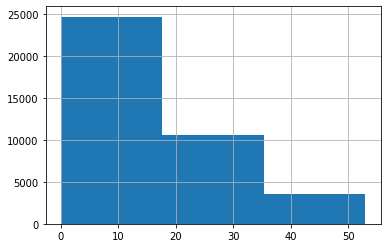

In [77]:
num_df[num_df.age < 99].age.hist(bins=3);

The idea at this point is to bin this into an encoded categorical. My idea is to bin them at the quartiles, so 0-5, 5-13, 13-25, and 25-53 and then the 'dropped' category is the ones with no age. Need to consult about this.

# Exploring categorical data

Because we still need the ID column, we can't just wholesale drop numerical columns from our raw_data. So we make a list of features to drop to make a dataframe of all our categorical data with 2 numerical features: the id, and the target.

In [78]:
num_features = ['amount_tsh', 'gps_height', 'longitude', 'latitude',
               'num_private', 'region_code', 'district_code', 'population',
               'construction_year']

cat_df = raw_df.drop(num_features, axis=1).copy()
list(cat_df.columns)

['id',
 'date_recorded',
 'funder',
 'installer',
 'wpt_name',
 'basin',
 'subvillage',
 'region',
 'lga',
 'ward',
 'public_meeting',
 'recorded_by',
 'scheme_management',
 'scheme_name',
 'permit',
 'extraction_type',
 'extraction_type_group',
 'extraction_type_class',
 'management',
 'management_group',
 'payment',
 'payment_type',
 'water_quality',
 'quality_group',
 'quantity',
 'quantity_group',
 'source',
 'source_type',
 'source_class',
 'waterpoint_type',
 'waterpoint_type_group',
 'target']

We already know that the 'id' feature is a unique numerical identifier. This will allow us to merge our cat_df with our num_df after investigative all the categorical variables. We already know that there are some features we will likely not use in modeling, such as 'date_recorded' and 'subvillage', so we will start a running drop list that will all be dropped before merging with numerical data.

In [79]:
drop_list = []

### Helper functions

In [80]:
def value_count_report(feature):
    """
    This is a helper function to report value counts for categeorical features 
    of the dataset and return a dataframe of the feature value counts for
    further investigation.
    
    Input(s):
    - 'feature' (required): string of feature to investigate
    
    Output(s):
    - 'feature_df': a DataFrame of the unique values and counts for the feature
    """
    # set up dataframe for unique values and counts. We have already dealt with
    # null values so no need to worry about including them here.
    feature_df = pd.DataFrame(cat_df[feature].value_counts())
    feature_df['percentage'] = round(cat_df[feature].value_counts(normalize=True)*100,2)
    
    # a second dataframe subset of the first where the value count is 1
    feature_df_singles = feature_df[feature_df[feature] == 1]
    
    # quick report on total unique values, how many are single, and what percent that is
    print(f"Unique values for '{feature}': {len(feature_df)}")
    print("--------------------------")
    print(f"Unique values with a single representative: {len(feature_df_singles)}")
    print(f"Percent of values that are single: {round((len(feature_df_singles)/len(feature_df)*100),2)}%")
    
    return feature_df

## date_recorded

The 'date_recorded' feature is likely not going to mean anything for analysis, and we have already used it to calculate ages of waterpoints. We will add this feature to our running drop list.

In [81]:
drop_list.append('date_recorded')

## funder

The data description states that this is who funded the well

In [82]:
funder_df = value_count_report('funder')

Unique values for 'funder': 1898
--------------------------
Unique values with a single representative: 974
Percent of values that are single: 51.32%


We have almost 1900 unique funders, just over half of which are represented just once. Lets look at the top 100 funders in groups of 10

In [83]:
for x in range(10, 110, 10):
    funder_total = funder_df['funder'][:x].sum()
    percent = round((funder_total / 59400) * 100, 2)
    print(f"Top {x} funders represent {funder_total} waterpoints, or {percent}%")

Top 10 funders represent 25225 waterpoints, or 42.47%
Top 20 funders represent 32461 waterpoints, or 54.65%
Top 30 funders represent 36586 waterpoints, or 61.59%
Top 40 funders represent 39417 waterpoints, or 66.36%
Top 50 funders represent 41503 waterpoints, or 69.87%
Top 60 funders represent 43173 waterpoints, or 72.68%
Top 70 funders represent 44522 waterpoints, or 74.95%
Top 80 funders represent 45739 waterpoints, or 77.0%
Top 90 funders represent 46819 waterpoints, or 78.82%
Top 100 funders represent 47728 waterpoints, or 80.35%


It's not looking like funder will be a good predictor. Maybe if we could separate out government, private, or other and make it 3 possible values. And really, if we think about it, the funder for the waterpump should not have too much impact on its status. As we understand it, this feature is just the organization that provided the money for the pump to be installed.

We will drop this feature from consideration.**open to input here**

In [84]:
drop_list.append('funder')

## installer

The data description states that this is who installed the well

In [85]:
installer_df = value_count_report('installer')

Unique values for 'installer': 2146
--------------------------
Unique values with a single representative: 1098
Percent of values that are single: 51.16%


Similar situation here as with funder, but with even more unique values. Lets look at the top 100 installers in groups of 10.

In [86]:
for x in range(10, 110, 10):
    installer_total = installer_df['installer'][:x].sum()
    percent = round((installer_total / 59400) * 100, 2)
    print(f"Top {x} installers represent {installer_total} waterpoints, or {percent}%")

Top 10 installers represent 29420 waterpoints, or 49.53%
Top 20 installers represent 34456 waterpoints, or 58.01%
Top 30 installers represent 37507 waterpoints, or 63.14%
Top 40 installers represent 39673 waterpoints, or 66.79%
Top 50 installers represent 41433 waterpoints, or 69.75%
Top 60 installers represent 42923 waterpoints, or 72.26%
Top 70 installers represent 44212 waterpoints, or 74.43%
Top 80 installers represent 45347 waterpoints, or 76.34%
Top 90 installers represent 46341 waterpoints, or 78.02%
Top 100 installers represent 47234 waterpoints, or 79.52%


The installer feature is in even worse position, made so because it stands to reason that the installation of a waterpoint would contribute to it's status later in operation. I don't see a way to make it meaningful though, considering that when we get new data we will have to find a way to categorize the installer if it doesn't fit into our schema. **open to input here**

In [87]:
drop_list.append('installer')

## wpt_name

The data description states that this is the name of the waterpoint, if there is one

In [88]:
wptname_df = value_count_report('wpt_name')

Unique values for 'wpt_name': 37400
--------------------------
Unique values with a single representative: 32928
Percent of values that are single: 88.04%


88% of our waterpoint names are represented by a single entry. Out of curiosity, lets look at our top 20 values.

In [89]:
wptname_top20 = wptname_df[:20]
wptname_top20.reset_index(inplace=True)
wptname_top20.columns = ['wpt_name', 'count', 'percentage']
wptname_top20

,wpt_name,count,percentage
0,none,3563,6.00
1,Shuleni,1748,2.94
2,Zahanati,830,1.40
3,Msikitini,535,0.90
4,Kanisani,323,0.54
5,Bombani,271,0.46
6,Sokoni,260,0.44
7,Ofisini,254,0.43
8,School,208,0.35
9,Shule Ya Msingi,199,0.34


Swahili is the national language of Tanzania. We are going to translate some of these names to see what they mean.

In [90]:
wptname_top20['translated'] = ['none','at school','clinics','in the mosque',
                               'church','none','none','office','school',
                               'primary school','school', 'secondary',
                               'in the congregation','savior', 'shops',
                               'in the park', 'hospital','love',
                               'health center', 'none']
wptname_top20

C:\Users\Brian\AppData\Local\Temp/ipykernel_10476/4249328915.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wptname_top20['translated'] = ['none','at school','clinics','in the mosque',


,wpt_name,count,percentage,translated
0,none,3563,6.00,none
1,Shuleni,1748,2.94,at school
2,Zahanati,830,1.40,clinics
3,Msikitini,535,0.90,in the mosque
4,Kanisani,323,0.54,church
5,Bombani,271,0.46,none
6,Sokoni,260,0.44,none
7,Ofisini,254,0.43,office
8,School,208,0.35,school
9,Shule Ya Msingi,199,0.34,primary school


Here would be an opportunity to expand if we could pull in translation and fuzzy logic for word types. Waterpoints are named after the place they are located and most of the ones with multiple value counts are at places like schools, houses of worship, offices, and shops. It will be too difficult at this point to find a way to convert this feature, so we will add it to the drop list. But if we could convert, it may be insightful if you could categorize the location type

In [91]:
drop_list.append('wpt_name')

## basin

The data description states that this a geographic water basin

In [92]:
basin_df = value_count_report('basin')

Unique values for 'basin': 9
--------------------------
Unique values with a single representative: 0
Percent of values that are single: 0.0%


In [93]:
basin_df

,basin,percentage
Lake Victoria,10248,17.25
Pangani,8940,15.05
Rufiji,7976,13.43
Internal,7785,13.11
Lake Tanganyika,6432,10.83
Wami / Ruvu,5987,10.08
Lake Nyasa,5085,8.56
Ruvuma / Southern Coast,4493,7.56
Lake Rukwa,2454,4.13


Nothing crazy looking here, we will need to encode this for modeling but we'll get to that after analysis of all categoricals

## subvillage

The data description states that this is a geographic location.

In [94]:
subvillage_df = value_count_report('subvillage')

Unique values for 'subvillage': 19288
--------------------------
Unique values with a single representative: 9424
Percent of values that are single: 48.86%


As we saw earlier when accounting for nulls we have a lot of subvillages, over 19 thousand, about half of which are represented by a single instance. We will not model with this, add it to the drop list.

In [95]:
drop_list.append('subvillage')

## region

The data description states that this is a geographic location

In [96]:
region_df = value_count_report('region')

Unique values for 'region': 21
--------------------------
Unique values with a single representative: 0
Percent of values that are single: 0.0%


We had already sorted out this feature. We will likely onehotencode this feature and not use region_code in modeling.

In [97]:
region_df

,region,percentage
Iringa,5300,8.92
Shinyanga,5011,8.44
Mbeya,4639,7.81
Kilimanjaro,4379,7.37
Morogoro,4040,6.80
Arusha,3350,5.64
Kagera,3324,5.60
Mwanza,3047,5.13
Kigoma,2816,4.74
Ruvuma,2640,4.44


## lga

The data description states that this is a geographic location.

In [98]:
lga_df = value_count_report('lga')

Unique values for 'lga': 125
--------------------------
Unique values with a single representative: 1
Percent of values that are single: 0.8%


In [99]:
lga_df[:20]

,lga,percentage
Njombe,2503,4.21
Arusha Rural,1252,2.11
Moshi Rural,1251,2.11
Bariadi,1177,1.98
Rungwe,1106,1.86
Kilosa,1094,1.84
Kasulu,1047,1.76
Mbozi,1034,1.74
Meru,1009,1.70
Bagamoyo,997,1.68


This doesn't seem to be too many values to onehotencode, but lets not jump to conclusions. This feature may have multicollinearity with region, because with only 21 regions and 125 values for lga, it stands to reason that most of these are just sub-divisions of larger regions.

We would have to decide, I think, between one or the other to use for modeling. My intuition is to keep the model simple and use 'region', but maybe we try one and then the other and see what results say.

One thing interesting that we learned is that Njombe, the most frequent value in lga, was actually established as a region of Tanzania in [March 2012](https://en.wikipedia.org/wiki/Njombe_Region). We can see that some of the lga values are rural or urban subzones of regions, such as Arusha and Kigoma, further supporting our position these names being smaller administrative areas.

## ward

The data description states that this is a geographic location


In [100]:
ward_df = value_count_report('ward')

Unique values for 'ward': 2092
--------------------------
Unique values with a single representative: 30
Percent of values that are single: 1.43%


In [101]:
ward_df

,ward,percentage
Igosi,307,0.52
Imalinyi,252,0.42
Siha Kati,232,0.39
Mdandu,231,0.39
Nduruma,217,0.37
...,...,...
Uchindile,1,0.00
Thawi,1,0.00
Uwanja wa Ndege,1,0.00
Izia,1,0.00


[Research shows](https://en.wikipedia.org/wiki/Subdivisions_of_Tanzania#:~:text=A%20Ward%20(Kata)%20is%20an,are%20composed%20of%20several%20villages.) that a ward is an administrative division, either urban or rural. This is another way to divide the data. I think we can try modeling with each of the three geographic divisions (region, lga, ward) to see which one performs best, but we will likely not need all 3. With ward, the largest percentage any one value has of the total data is about one half of one percent, so this may be too much division.

## public_meeting

The data description states that this is a true/false if there was a public meeting

In [102]:
public_meeting_df = value_count_report('public_meeting')

Unique values for 'public_meeting': 2
--------------------------
Unique values with a single representative: 0
Percent of values that are single: 0.0%


I'm not sure if this will impact modeling, but it's a simple boolean so we will leave it in for now (will encode at the end of categorical analysis).

## recorded_by

The data description states that this is who entered the data

In [103]:
recorded_by_df = value_count_report('recorded_by')

Unique values for 'recorded_by': 1
--------------------------
Unique values with a single representative: 0
Percent of values that are single: 0.0%


In [104]:
recorded_by_df

,recorded_by,percentage
GeoData Consultants Ltd,59400,100.0


We do not need this feature, adding to the drop list.

In [105]:
drop_list.append('recorded_by')

## scheme_management

The data description states that this is who operates the waterpoint

In [106]:
scheme_management_df = value_count_report('scheme_management')

Unique values for 'scheme_management': 11
--------------------------
Unique values with a single representative: 0
Percent of values that are single: 0.0%


In [107]:
scheme_management_df

,scheme_management,percentage
VWC,39346,66.24
WUG,5560,9.36
Water authority,3377,5.69
WUA,3085,5.19
Water Board,2941,4.95
Parastatal,1805,3.04
Company,1155,1.94
Private operator,1133,1.91
Other,821,1.38
SWC,100,0.17


We will need to encode this feature to model, and it's likely to be important.

## scheme_name

The data description states that this is who operates the waterpoint

In [108]:
scheme_name_df = value_count_report('scheme_name')

Unique values for 'scheme_name': 2697
--------------------------
Unique values with a single representative: 712
Percent of values that are single: 26.4%


In [109]:
scheme_name_df

,scheme_name,percentage
Other,28166,47.42
K,682,1.15
None,644,1.08
Borehole,546,0.92
Chalinze wate,405,0.68
...,...,...
Visiga water supplly,1,0.00
Emanyata pipelines,1,0.00
Magundi water supply,1,0.00
Imalampaka water supply,1,0.00


Almost half (47.42%) of our scheme_name data is 'Other'. The remaining values are very sparse, the next most frequent being 'K' at 1.15%. I don't suspect there is a way to use this data. Adding to the drop list.

In [110]:
drop_list.append('scheme_name')

## permit

The data description states that this feature indicates if the waterpoint is permitted.

In [111]:
permit_df = value_count_report('permit')

Unique values for 'permit': 2
--------------------------
Unique values with a single representative: 0
Percent of values that are single: 0.0%


In [112]:
permit_df

,permit,percentage
True,40937,68.92
False,18463,31.08


We will certainly use this feature and numerically encode it at the end

## extraction_type

The data description states that this the kind of extraction the waterpoint uses.

In [113]:
extraction_type_df = value_count_report('extraction_type')

Unique values for 'extraction_type': 18
--------------------------
Unique values with a single representative: 0
Percent of values that are single: 0.0%


In [114]:
extraction_type_df

,extraction_type,percentage
gravity,26780,45.08
nira/tanira,8154,13.73
other,6430,10.82
submersible,4764,8.02
swn 80,3670,6.18
mono,2865,4.82
india mark ii,2400,4.04
afridev,1770,2.98
ksb,1415,2.38
other - rope pump,451,0.76


## extraction_type_group

## extraction_type_class

## management

## management_group

## payment

## payment_type

## water_quality

## quality_group

## quantity

## quantity_group

## source

## source_type

## source_class

## waterpoint_type

## waterpoint_type_group